# 前言
在上篇中，我们简单学习了图论的基本概念，图的表示和存储方式，同构图和异构图的分类，以及几个基础的图论算法。 在接下来的前置教程下篇中，我们将会学习图机器学习。

本案例主要就 图机器学习（GML：Graph Machine Learning）进行讲解

首先我们导入需要的包

In [58]:
import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# 图机器学习
## 图学习的主要任务
图学习中包含三种主要的任务：

* 链接预测（Link prediction）
* 节点标记预测（Node labeling）
* 图嵌入（Graph Embedding）

## 链接预测（Link prediction）

> 在链接预测中，给定图G，我们的目标是预测新边。例如，当图未被完全观察时，或者当新客户加入平台（例如，新的LinkedIn用户）时，预测未来关系或缺失边是很有用的。 [知乎回答：如何理解链接预测（link prediction）](https://www.zhihu.com/question/273499382/answer/652082619)

新LinkedIn用户的链接预测只是给出它可能认识的人的建议。

在链路预测中，我们只是尝试在节点对之间建立相似性度量，并链接最相似的节点。现在的问题是识别和计算正确的相似性分数！

为了说明图中不同链路的相似性差异，让我们通过下面这个图来解释：

![](https://ai-studio-static-online.cdn.bcebos.com/ebf4b553f3a346f58e367e4c9990c180cc4a2752e1214506aacbefe688f777c7)

设$N(i)$是节点i的一组邻居。在上图中，节点i和j的邻居可以表示为：

![](https://ai-studio-static-online.cdn.bcebos.com/528c6a9407c64302b9f51ae6c7f694b83763d730021843609c25a53984b1ad68)

i的邻居：

![](https://ai-studio-static-online.cdn.bcebos.com/ef3b08f483ba42f480f4c01e4ba5e065bed5ecc6f08147159907465a021b1fd9)

1. 相似度分数
我们可以根据它们的邻居为这两个节点建立几个相似度分数。

- 公共邻居：$S(i,j) = \mid N(i) \cap N(j) \mid$，即公共邻居的数量。在此示例中，分数将为2，因为它们仅共享2个公共邻居。

![](https://ai-studio-static-online.cdn.bcebos.com/1d3507fa1a8c4bfbaadcae695192c149815daf889ddb4e2c8e80fd40b6999c0e)

- Jaccard系数：$S(i,j) = \frac { \mid N(i) \cap N(j) \mid } { \mid N(i) \cup N(j) \mid }$,标准化的共同邻居版本。

交集是共同的邻居，并集是：

![](https://ai-studio-static-online.cdn.bcebos.com/202acfa187df4a97b2ed11ab25c4458c73fef1d7d8af4db3a547f3099c35a1b6)

因此，Jaccard系数由粉红色与黄色的比率计算出：

![](https://ai-studio-static-online.cdn.bcebos.com/c22bac26504d4bb78135d78bd83d660a513aa3ba0f8b4799a3583c60ef8dd2a5)

值是$\frac {1} {6}$

- Adamic-Adar指数：$S(i,j) = \sum_{k \in N(i)\cap N(j) } \frac {1} {\log \mid N(k) \mid}$。对于节点i和j的每个公共邻居（common neighbor），我们将1除以该节点的邻居总数。这个概念是，当预测两个节点之间的连接时，与少量节点之间共享的元素相比，具有非常大的邻域的公共元素不太重要。
- 优先依附(Preferential attachment)： $S(i,j) = \mid N(i) \mid * \mid N(j) \mid$
- 当社区信息可用时，我们也可以在社区信息中使用它们。

2. 性能指标(Performance metrics)

我们如何进行链接预测的评估？我们必须隐藏节点对的子集，并根据上面定义的规则预测它们的链接。这相当于监督学习中的train/test的划分。 然后，我们评估密集图的正确预测的比例，或者使用稀疏图的标准曲线下的面积(AUC)。

这里继续用空手道俱乐部图来举例：



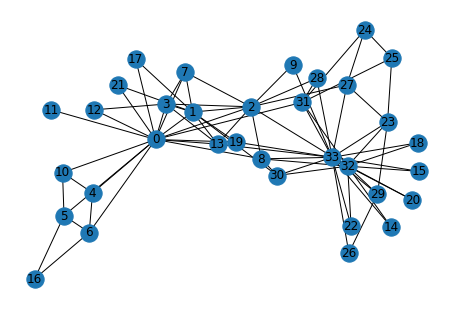

In [59]:
# 我们导入空手道俱乐部图
n=34
m = 78
G_karate = nx.karate_club_graph()

pos = nx.spring_layout(G_karate)
nx.draw(G_karate, cmap = plt.get_cmap('rainbow'), with_labels=True, pos=pos)

In [60]:
# 我们首先把有关图的信息打印出来：
n = G_karate.number_of_nodes()
m = G_karate.number_of_edges()
print("Number of nodes : %d" % n)
print("Number of edges : %d" % m)
print("Number of connected components : %d" % nx.number_connected_components(G_karate)) # 连通分量数

Number of nodes : 34
Number of edges : 78
Number of connected components : 1


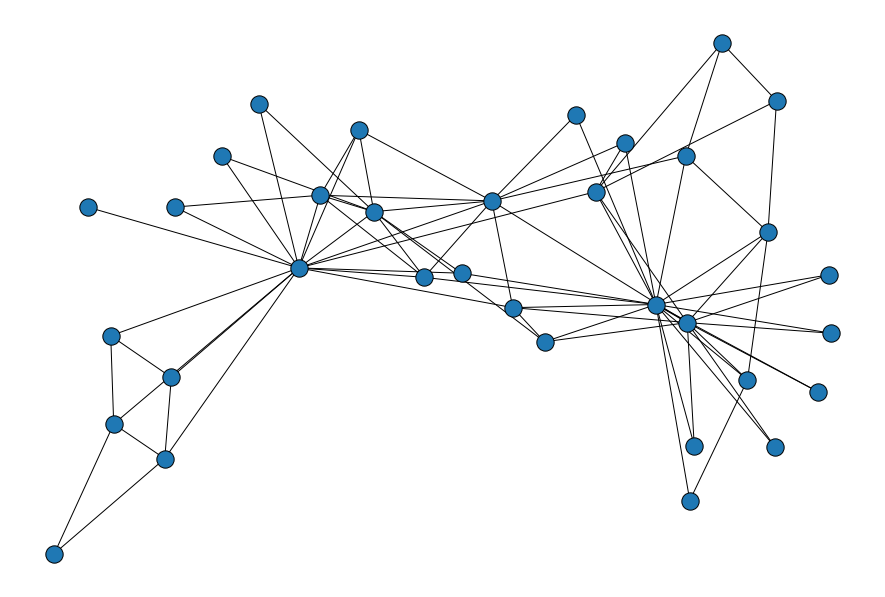

In [61]:
plt.figure(figsize=(12,8))
nx.draw(G_karate, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000")

In [62]:
# 现在，让我们删除一些连接，例如25％的边：
# Take a random sample of edges
edge_subset = random.sample(G_karate.edges(), int(0.25 * G_karate.number_of_edges()))

# remove some edges
G_karate_train = G_karate.copy()
G_karate_train.remove_edges_from(edge_subset)

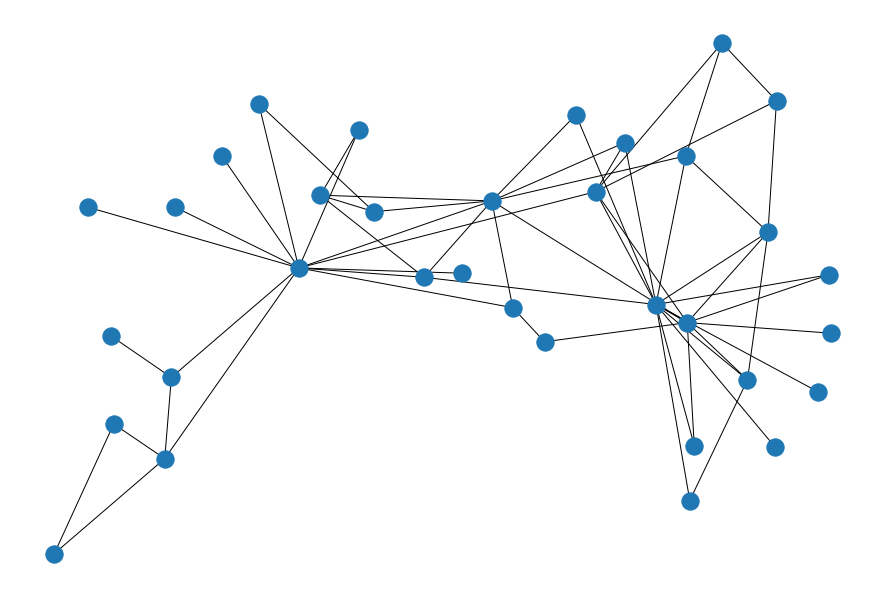

In [63]:

# 绘制部分观察到的图，可以对比上图发现，去掉了一些边
plt.figure(figsize=(12,8))
nx.draw(G_karate_train, pos=pos)

In [64]:
# 你可以打印我们删除的边数和剩余边数：
edge_subset_size = len(list(edge_subset))
print("Deleted : ", str(edge_subset_size))
print("Remaining : ", str((m - edge_subset_size)))

Deleted :  19
Remaining :  59


**计算Jaccard Coefficient**

In [65]:
# 我们可以先使用Jaccard系数进行预测：
# Make prediction using Jaccard Coefficient
pred_jaccard = list(nx.jaccard_coefficient(G_karate_train))
score_jaccard, label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_jaccard])
# 打印前10组结果
print(pred_jaccard[0:10])
# 预测结果如下，其中第一个是节点，第二个是节点，最后一个是Jaccard分数（用来表示两个节点之间边预测的概率）

[(0, 1, 0.15384615384615385), (0, 3, 0.23076923076923078), (0, 5, 0.07692307692307693), (0, 9, 0.07692307692307693), (0, 10, 0.08333333333333333), (0, 14, 0.0), (0, 15, 0.0), (0, 16, 0.07692307692307693), (0, 18, 0.0), (0, 20, 0.0)]


In [66]:
# 然后我们可以使用ROC-AUC标准来比较不同模型的性能，因为我们既有真实的边（label），也有预测边的概率（score）
# Compute the ROC AUC Score
# 其中，FPR是False Positive Rate， TPR是True Positive Rate
fpr_jaccard, tpr_jaccard, _ = roc_curve(label_jaccard, score_jaccard)
auc_jaccard = roc_auc_score(label_jaccard, score_jaccard)
print(auc_jaccard)

0.5707202789582652


**计算Adamic-Adar**

In [67]:
# 我们现在计算Adamic-Adar指数和对应的ROC-AUC分数
# Prediction using Adamic Adar 
pred_adamic = list(nx.adamic_adar_index(G_karate_train))
score_adamic, label_adamic = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_adamic])
print(pred_adamic[0:10])
# Compute the ROC AUC Score
fpr_adamic, tpr_adamic, _ = roc_curve(label_adamic, score_adamic)
auc_adamic = roc_auc_score(label_adamic, score_adamic)
print(auc_adamic)

[(0, 1, 1.897814654202382), (0, 3, 2.6191621746468634), (0, 5, 0.7213475204444817), (0, 9, 0.45511961331341866), (0, 10, 0.9102392266268373), (0, 14, 0), (0, 15, 0), (0, 16, 0.7213475204444817), (0, 18, 0), (0, 20, 0)]
0.6802331916748392


**计算Preferential Attachment**

In [68]:
# 同样，我们可以计算Preferential Attachment得分和对应的ROC-AUC分数
# Compute the Preferential Attachment
pred_pref = list(nx.preferential_attachment(G_karate_train))
score_pref, label_pref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in pred_pref])
print(pred_pref[0:10])
fpr_pref, tpr_pref, _ = roc_curve(label_pref, score_pref)
auc_pref = roc_auc_score(label_pref, score_pref)
print(auc_pref)

[(0, 1, 36), (0, 3, 48), (0, 5, 24), (0, 9, 24), (0, 10, 12), (0, 14, 12), (0, 15, 12), (0, 16, 24), (0, 18, 24), (0, 20, 12)]
0.6993026043369293


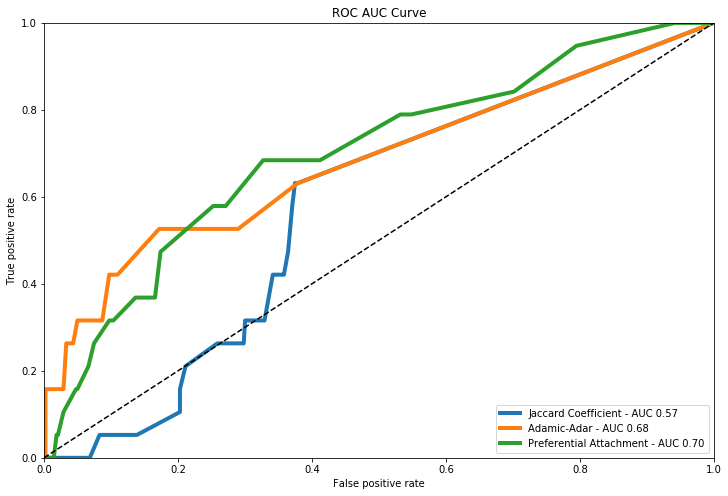

In [69]:
plt.figure(figsize=(12, 8))
plt.plot(fpr_jaccard, tpr_jaccard, label='Jaccard Coefficient - AUC %.2f' % auc_jaccard, linewidth=4)
plt.plot(fpr_adamic, tpr_adamic, label='Adamic-Adar - AUC %.2f' % auc_adamic, linewidth=4)
plt.plot(fpr_pref, tpr_pref, label='Preferential Attachment - AUC %.2f' % auc_pref, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC AUC Curve")
plt.legend(loc='lower right')
plt.show() 

指标参考：

[模型评估指标AUC和ROC，这是我看到的最透彻的讲解](https://cloud.tencent.com/developer/article/1508882)

# 节点标记预测（Node labeling）
> 给定一个未标记某些节点的图，我们希望对这些节点的标签进行预测。这在某种意义上是一种半监督的学习问题。

处理这些问题的一种常见方法是假设图上有一定的平滑度。平滑度假设指出通过数据上的高密度区域的路径连接的点可能具有相似的标签。这是标签传播算法背后的主要假设。

标签传播算法（Label Propagation Algorithm,LPA）是一种快速算法，仅使用网络结构作为指导来发现图中的社区，而无需任何预定义的目标函数或关于社区的先验信息。

![](https://ai-studio-static-online.cdn.bcebos.com/8c3d7246a09743fc919303b2407aa73340df1640ad9a4e17996c4ab53b2a4dfb)

单个标签在密集连接的节点组中迅速占据主导地位，但是在穿过稀疏连接区域时会遇到问题。

半监督标签传播算法是如何工作？

首先，我们有一些数据：$x_1, ..., x_l, x_{l+1}, ..., x_n \in R^p$，以及前lll个点的标签：$y_1, ..., y_l \in 1...C$

我们定义初始标签矩阵$Y \in R^{n \times C}$，如果$x_i$具有标签$y_i=j$则$Y_{ij} = 1$，否则为0。

该算法将生成预测矩阵$CF \in R^{n \times C}$，我们将在下面详述。然后，我们通过查找最可能的标签来预测节点的标签：

$$\hat{Y_i} = argmax_j F_{i,j} $$

预测矩阵$F$是什么？

预测矩阵是矩阵$F^{\star}$，其最小化平滑度和准确度。因此，我们的结果在平滑性和准确性之间进行权衡。

问题的描述非常复杂，所以我将不会详细介绍。但是，解决方案是：

$$F^{\star} = ( (1-\alpha)I + L_{sym})^{-1} Y$$

其中：

- 参数$\alpha = \frac {1} {1+\mu}$
- $Y$是给定的标签
- $L_{sym}$是图的归一化拉普拉斯矩阵（Laplacian matrix）

如果您想进一步了解这个主题，请关注图函数的平滑度和流形正则化的概念。

接下来我们用python来实现节点标签的预测。 为了给我们使用到的标签添加更多的特征，我们需要使用来自Facebook的真实数据。数据集在word压缩包里面解压出来就行.

In [70]:
G_fb = nx.read_edgelist("work/facebook/414.edges")
n = G_fb.number_of_nodes()
m = G_fb.number_of_edges()

print("Number of nodes: %d" % n)
print("Number of edges: %d" % m)
print("Number of connected components: %d" % nx.number_connected_components(G_fb))

Number of nodes: 150
Number of edges: 1693
Number of connected components: 2


我们使用到的414号数据，图中有150个节点和1693个边。其中，有2个连通分支构成，这意味着这个图中的两块是分开来的。

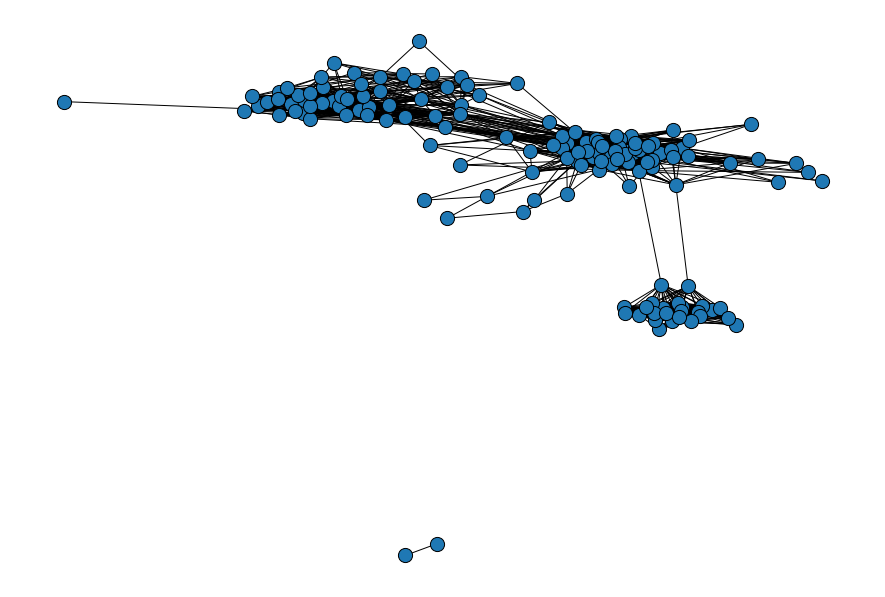

In [71]:
# 我们把图数据显示出来：
mapping=dict(zip(G_fb.nodes(), range(n)))
nx.relabel_nodes(G_fb, mapping, copy=False)
pos = nx.spring_layout(G_fb)

plt.figure(figsize=(12,8))
nx.draw(G_fb, node_size=200, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000")

这个图中包含了不同的特征。在这些可用的特征中，我们将利用第34组特征来进行实验。这组特征描述了这个某个facebook用户（节点）是否是一所学校的学生。 这里我们两种标签（1是红色的，代表改用户是这所学校的学生，反正，0则用蓝色表示）

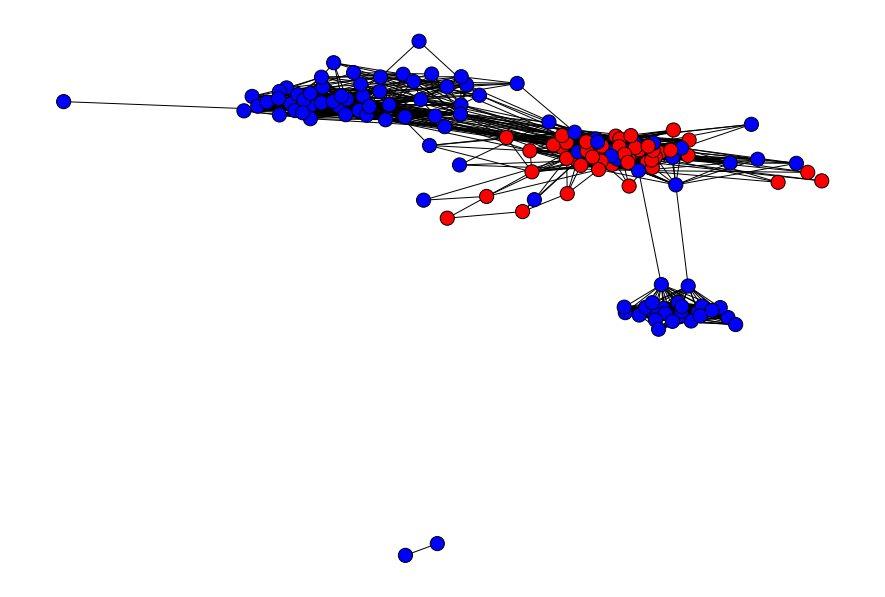

In [72]:
with open('./work/facebook/414.featnames') as f:
    for i, l in enumerate(f):
        pass

n_feat = i+1

features = np.zeros((n, n_feat))
f = open('./work/facebook/414.feat', 'r')

for line in f:
    if line.split()[0] in mapping:
        node_id = mapping[line.split()[0]]
        features[node_id, :] = list(map(int, line.split()[1:]))

features = 2*features-1
feat_id = 43
labels = features[:, feat_id]

plt.figure(figsize=(12,8))
nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = labels, node_size=200, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000")
plt.show()

这个所选择的特征，在图中相对平滑，因此拥有较好的学习传播性能。

为了阐述节点标签预测是如何进行的，我们首先要删掉一些节点的标签，作为要预测的对象。这里我们只保留了30%的节点标签：

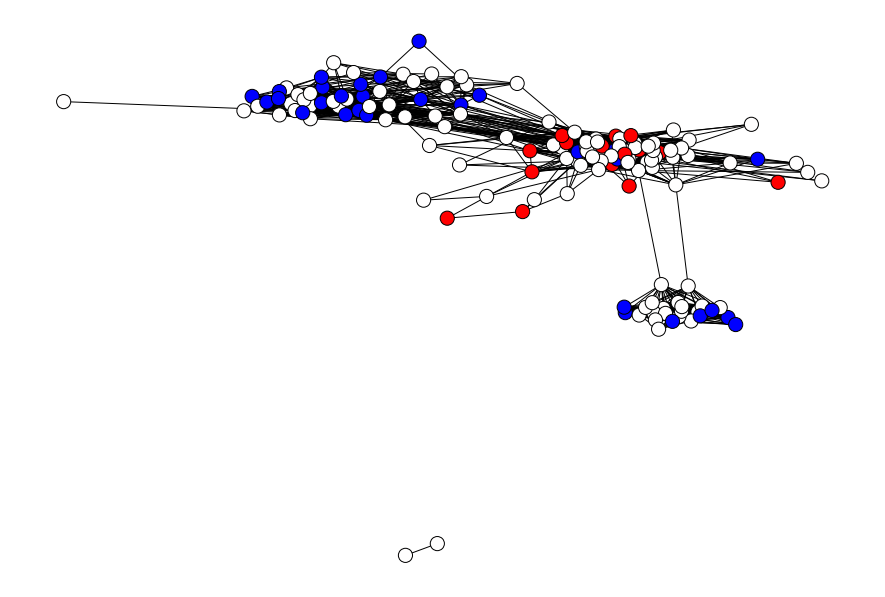

In [73]:
random.seed(5)
proportion_nodes = 0.3
labeled_nodes = random.sample(G_fb.nodes(), int(proportion_nodes * G_fb.number_of_nodes()))

known_labels = np.zeros(n)
known_labels[labeled_nodes] = labels[labeled_nodes]

plt.figure(figsize=(12,8))
nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = known_labels, node_size=200, pos=pos)
plt.gca().collections[0].set_edgecolor("#000000") # set node border color to black
plt.show()

然后，我们就可以进行标签的传播预测

In [74]:
alpha = 0.7
L_sym = nx.normalized_laplacian_matrix(G_fb)

Y = np.zeros((n,2))
Y[known_labels==-1, 0] = 1
Y[known_labels==1, 1] = 1
I = np.identity(n)

# Create the F-pred matrix
F_pred = np.linalg.inv(I*(1-alpha) + L_sym) * Y
# Identify the prediction as the argmax
pred = np.array(np.argmax(F_pred, axis=1)*2-1).flatten()
# Compute the accuracy score
succ_rate = accuracy_score(labels, pred)

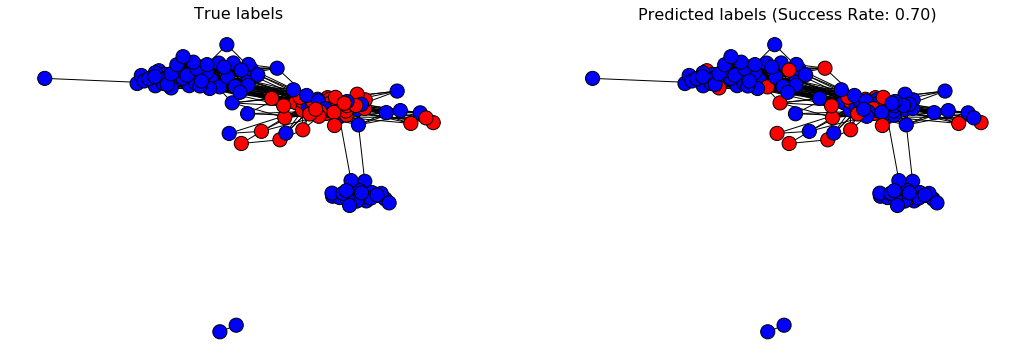

In [75]:
# 我们把结果打印出来
plt.figure(figsize=(18, 6))
f, axarr = plt.subplots(1, 2, num=1)

# Plot true values
plt.sca(axarr[0])
nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = labels, node_size=200, pos=pos)
axarr[0].set_title('True labels', size=16)
plt.gca().collections[0].set_edgecolor("#000000")

# Plot predicted values
plt.sca(axarr[1])
nx.draw(G_fb, cmap = plt.get_cmap('bwr'), nodelist=range(n), node_color = pred, node_size=200, pos=pos)
axarr[1].set_title('Predicted labels (Success Rate: %.2f)' % succ_rate, size=16)
plt.gca().collections[0].set_edgecolor("#000000")

这就是我们得到的预测结果，如上右图所示。

# 图嵌入（Graph Embedding）
在处理NLP或计算机视觉问题时，我们习惯在深度神经网络中对图像或文本进行嵌入(embedding)。到目前为止，我们所看到的图的一个局限性是没有向量特征。但是，我们可以学习图的嵌入！图有不同几个级别的嵌入：

* 对图的组件进行嵌入（节点，边，特征…）(Node2Vec)
* 对图的子图或整个图进行嵌入(Graph2Vec)